In [1]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd

In [2]:
train_neural = np.load('../input/features/train_neural_features.npy')
train_statistical = np.load('../input/features/train_statistical_features.npy')
train_external = np.load('../input/features/train_external_features.npy')

In [3]:
train_neural.shape,train_external.shape,train_statistical.shape

((49972, 4800), (49972, 60), (49972, 10000))

In [4]:
stance_to_index = {'agree': 0, 'disagree': 1, 'discuss': 2, 'unrelated': 3}
index_to_stance = {0: 'agree', 1: 'disagree', 2: 'discuss', 3: 'unrelated'}

In [5]:
df_train = pd.read_csv('../input/datafiles/train_Set.csv')
Y_train = df_train[['Stance']].values.tolist()

In [6]:
def to_categorical(Y, num_classes):
    final_Y = np.zeros((len(Y), num_classes))
    for i, stance in enumerate(Y):
        final_Y[i][stance_to_index[stance[0]]] = 1
    return final_Y

Y_train = to_categorical(Y_train, num_classes=4)

In [7]:
train_neural_tensor = torch.tensor(train_neural, dtype=torch.float32)
train_statistical_tensor = torch.tensor(train_statistical, dtype=torch.float32)
train_external_tensor = torch.tensor(train_external, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
print(train_neural_tensor.shape,train_external_tensor.shape,train_statistical_tensor.shape,Y_train_tensor.shape)
len(train_neural_tensor)

torch.Size([49972, 4800]) torch.Size([49972, 60]) torch.Size([49972, 10000]) torch.Size([49972, 4])


49972

In [9]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        # Define the first branch
        self.x_model = nn.Sequential(
            nn.Linear(4800, 500),
            nn.Sigmoid(),
            nn.Dropout(0.2),
            nn.Linear(500, 100),
            nn.Sigmoid()
        )

        # Define the second branch
        self.y_model = nn.Sequential(
            nn.Linear(10000, 500),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(500, 50),
            nn.ReLU()
        )

        # Define the third branch
        self.z_model = nn.Sequential(
            nn.Linear(60, 60),
            nn.ReLU()
        )

        # Combine the three branches
        self.fc_combined = nn.Sequential(
            nn.Linear(100 + 50 + 60, 4),
            nn.Softmax(dim=1)
        )

    def forward(self, x, y, z):
        x_out = self.x_model(x)
        y_out = self.y_model(y)
        z_out = self.z_model(z)
        combined = torch.cat([x_out, y_out, z_out], dim=1)
        output = self.fc_combined(combined)
        return output

# Instantiate the model
model = MyModel().to(device)

In [10]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 30
batch_size = 200

In [11]:
for epoch in range(epochs):
    model.train()
    run_loss = 0.0
    for i in range(0, len(train_neural_tensor), batch_size):
        x_batch = train_neural_tensor[i:i+batch_size]
        y_batch = train_external_tensor[i:i+batch_size]
        z_batch = train_statistical_tensor[i:i+batch_size]
        labels = Y_train_tensor[i:i+batch_size]
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        x_batch,y_batch,z_batch = x_batch.to(device),y_batch.to(device),z_batch.to(device)
        labels = labels.to(device)
        outputs = model(x_batch, z_batch, y_batch)
        loss = criterion(outputs, torch.argmax(labels, dim=1))

        # Backward pass and optimization
        loss.backward()
        run_loss += loss.item()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {run_loss/len(train_neural_tensor)}')

# Save the model
torch.save(model.state_dict(), 'final_model.pth')

Epoch [1/30], Loss: 0.004343767141042007
Epoch [2/30], Loss: 0.004235667117428457
Epoch [3/30], Loss: 0.004211758802462491
Epoch [4/30], Loss: 0.004198273104872475
Epoch [5/30], Loss: 0.0041919580612229945
Epoch [6/30], Loss: 0.00418852862690196
Epoch [7/30], Loss: 0.004186218244380778
Epoch [8/30], Loss: 0.004183222099519621
Epoch [9/30], Loss: 0.00417997619292376
Epoch [10/30], Loss: 0.004167429918543615
Epoch [11/30], Loss: 0.004022994353850791
Epoch [12/30], Loss: 0.00395180874200815
Epoch [13/30], Loss: 0.003914444954011893
Epoch [14/30], Loss: 0.003894730126143055
Epoch [15/30], Loss: 0.0038772365767894904
Epoch [16/30], Loss: 0.0038695684115670845
Epoch [17/30], Loss: 0.0038636570065357207
Epoch [18/30], Loss: 0.0038590834831720086
Epoch [19/30], Loss: 0.0038565411217875087
Epoch [20/30], Loss: 0.003853043488979836
Epoch [21/30], Loss: 0.0038472434090888598
Epoch [22/30], Loss: 0.003845985946935429
Epoch [23/30], Loss: 0.003843606312719785
Epoch [24/30], Loss: 0.0038430328511985

In [12]:
test_neural = np.load('../input/features/test_neural_features.npy')
test_statistical = np.load('../input/features/test_statistical_features.npy')
test_external = np.load('../input/features/test_external_features.npy')

In [13]:
test_neural.shape,test_statistical.shape,test_external.shape

((25413, 4800), (25413, 10000), (25413, 60))

In [14]:
df_test = pd.read_csv('../input/datafiles/test_Set.csv')
Y_test = df_test[['Stance']].values.tolist()
Y_res = Y_test

In [15]:
Y_test = to_categorical(Y_test, num_classes=4)

In [16]:
model.eval()

MyModel(
  (x_model): Sequential(
    (0): Linear(in_features=4800, out_features=500, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=500, out_features=100, bias=True)
    (4): Sigmoid()
  )
  (y_model): Sequential(
    (0): Linear(in_features=10000, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=500, out_features=50, bias=True)
    (4): ReLU()
  )
  (z_model): Sequential(
    (0): Linear(in_features=60, out_features=60, bias=True)
    (1): ReLU()
  )
  (fc_combined): Sequential(
    (0): Linear(in_features=210, out_features=4, bias=True)
    (1): Softmax(dim=1)
  )
)

In [17]:
test_neural_tensor = torch.tensor(test_neural, dtype=torch.float32)
test_statistical_tensor = torch.tensor(test_statistical, dtype=torch.float32)
test_external_tensor = torch.tensor(test_external, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

In [18]:
print(test_neural_tensor.shape,test_external_tensor.shape,test_statistical_tensor.shape,Y_test_tensor.shape)
len(test_neural_tensor)

torch.Size([25413, 4800]) torch.Size([25413, 60]) torch.Size([25413, 10000]) torch.Size([25413, 4])


25413

In [19]:
predicted = None
with torch.no_grad():
    outputs = model(test_neural_tensor.to(device),test_statistical_tensor.to(device),test_external_tensor.to(device))
    _, predicted = torch.max(outputs, 1)

In [20]:
predictions = [index_to_stance[p.item()] for p in predicted.cpu().numpy()]
# predictions = np.array(predictions)

In [21]:
Y_res = [item for sublist in Y_res for item in sublist]
type(predictions),type(Y_res)

(list, list)

In [22]:
LABELS = ['agree', 'disagree', 'discuss', 'unrelated']
LABELS_RELATED = ['unrelated', 'related']
RELATED = LABELS[0:3]

In [23]:
def score_submission(gold_labels, test_labels):
    score = 0.0
    cm = [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]]

    for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance != 'unrelated':
                score += 0.50
        if g_stance in RELATED and t_stance in RELATED:
            score += 0.25

        cm[LABELS.index(g_stance)][LABELS.index(t_stance)] += 1

    return score, cm

In [24]:
score, cm = score_submission(Y_res, predictions)

In [25]:
print(f'Score: {score}')
print(np.array(cm))

Score: 9499.0
[[  942     0   831   130]
 [  252     0   322   123]
 [  562     0  3612   290]
 [  142     0   394 17813]]


In [26]:
predictions = np.array(predictions)
Y_res = np.array(Y_res)
predictions.shape,Y_res.shape

((25413,), (25413,))

Classification Report:
              precision    recall  f1-score   support

       agree       0.50      0.50      0.50      1903
    disagree       0.00      0.00      0.00       697
     discuss       0.70      0.81      0.75      4464
   unrelated       0.97      0.97      0.97     18349

    accuracy                           0.88     25413
   macro avg       0.54      0.57      0.55     25413
weighted avg       0.86      0.88      0.87     25413



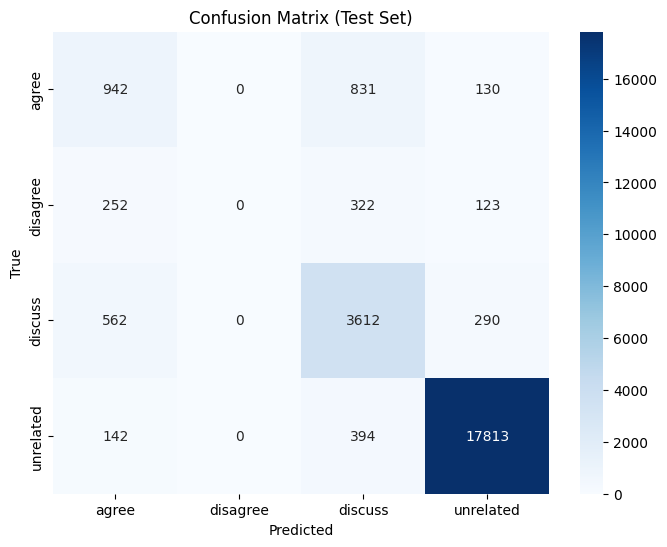

Accuracy: 0.8801400857828671


In [27]:
# Calculate metrics

print("Classification Report:")
print(classification_report(np.array(Y_res), predictions, target_names=['agree','disagree','discuss','unrelated']))

cm_test = confusion_matrix(np.array(Y_res), predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['agree','disagree','discuss','unrelated'], yticklabels=['agree','disagree','discuss','unrelated'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()

accuracy = accuracy_score(np.array(Y_res), predictions)
print(f"Accuracy: {accuracy}")